In [4]:
import numpy as np
import numpy.linalg as mat
import scipy as sp
import scipy.linalg as smat

# from json import JSONDecodeError
import simplejson

# import cvxpy as cp
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import peartree as pt #turns GTFS feed into a graph
import folium

import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

from matplotlib.patches import FancyArrow
from itertools import product 
from random import sample
from shapely.geometry import Polygon, Point
import shapely as shp
import plotly.express as px

import alphashape
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import time

# from gtfs_functions import Feed #, map_gdf
import gtfs_functions as gtfs

import pickle

## imports

In [5]:
%load_ext autoreload
%autoreload 2
from multimodal_functions import * 


# LOAD WORLD0

In [6]:
reload_base = True;
#filename = 'data/data1176.obj'
# filename = 'data/data1073.obj';
filename = 'runs/data2524.obj';
# filename = 'data/data353.obj'
# filename = 'data/data103.obj'

if reload_base:
    file = open(filename, 'rb')
    DATA = pickle.load(file)
    DATA = pd.read_pickle(filename)
    file.close()
    
reread_data = True;
if reread_data:
    WORLD0 = DATA['WORLD'];
    NDF = DATA['NDF']
    NODES = DATA['NODES']
    BUS_STOP_NODES = DATA['BUS_STOP_NODES']

FileNotFoundError: [Errno 2] No such file or directory: 'runs/data2524.obj'

# -----------------------ONLY IF RECOMPUTE DATA ---------------------------
# -----------------------ONLY IF RECOMPUTE DATA ---------------------------

# LOADING GRAPH/NETWORK DATA (takes 30 secs...)

In [7]:
szz = 1.; radius = szz*5000;
start = 8*60*60; end = 9*60*60;
time_window = [start,end]

center_point = (-85.3094,35.0458)
bnds = generate_bnds(center_point)
OUT = SETUP_GRAPHS_CHATTANOOGA(center_point,radius,time_window); #,bnds = bnds);
GRAPHS = OUT['GRAPHS']; RGRAPHS = OUT['RGRAPHS']; feed = OUT['feed']

INFO:root:Reading "stops.txt".
INFO:root:Reading "stop_times.txt".
INFO:root:get trips in stop_times
INFO:root:accessing trips
INFO:root:Reading "routes.txt".
INFO:root:Reading "trips.txt".
INFO:root:Reading "calendar.txt".
INFO:root:Reading "calendar_dates.txt".
INFO:root:The busiest date/s of this feed or your selected date range is/are:  ['2020-12-25', '2021-01-01', '2020-11-26', '2020-09-07'] with 1230 trips.
INFO:root:In that more than one busiest date was found, the first one will be considered.
INFO:root:In this case is 2020-12-25.
INFO:root:Reading "stop_times.txt".


loading feed...
constructing transit graph from feed...


INFO:root:_trips is defined in stop_times
INFO:root:computing patterns
INFO:root:Reading "shapes.txt".
INFO:root:segments_df: 2113, geometry: 2113


loading drive graph...
loading walk graph...
composing graphs...
computing reverse graphs...
...reversing drive graph...
...reversing walk graph...
...reversing transit graph...
...reversing ondemand graph...
...reversing gtfs graph...
...reversing all graph...
connecting close bus stops...
Original num of edges:  2113
Final num of edges:  3849


# ... plotting...(takes a few secs...)

CPU times: user 299 ms, sys: 9.73 ms, total: 309 ms
Wall time: 197 ms


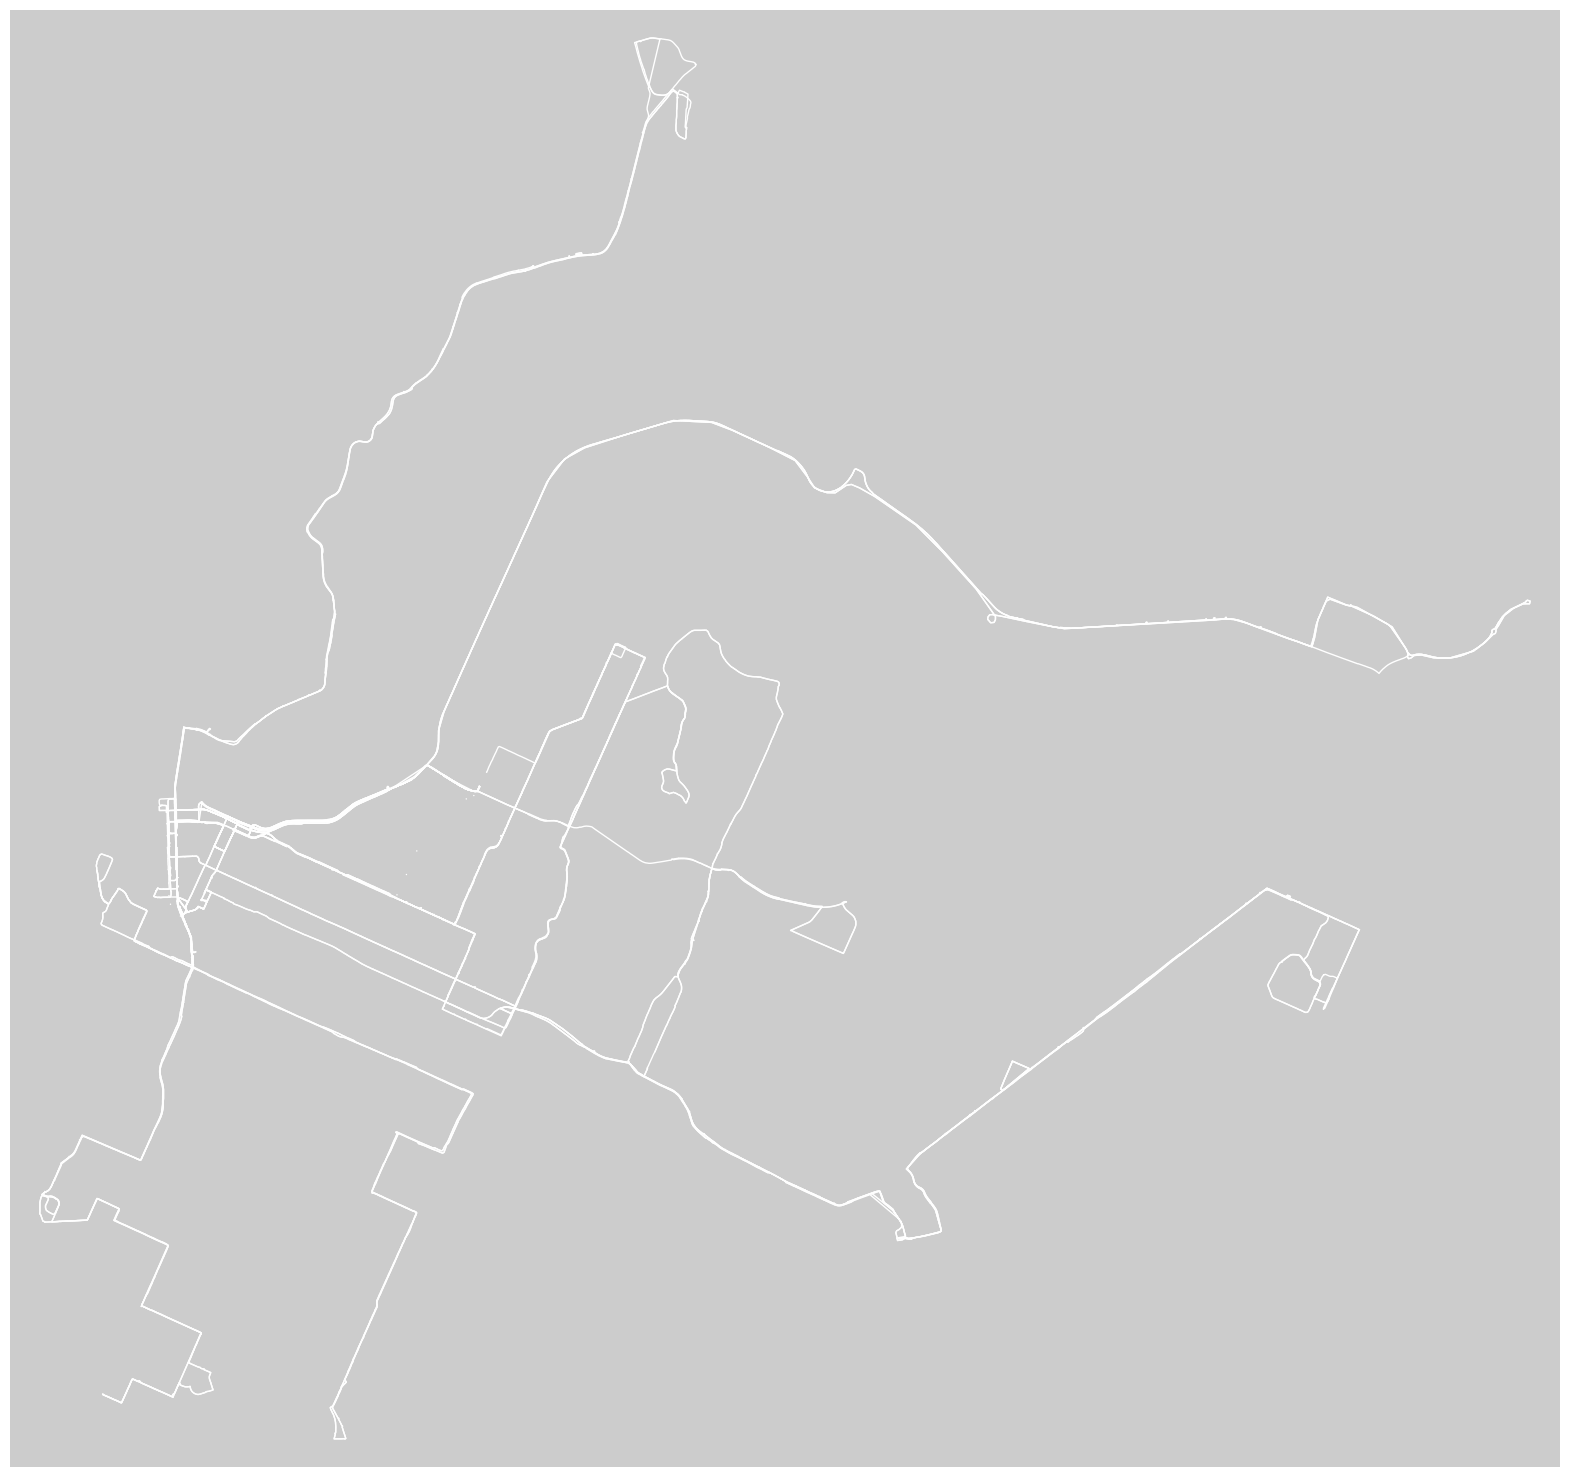

In [9]:
#graph_bus = load_feed_as_graph(feed);
mode = 'transit';
bgcolor = [0.8,0.8,0.8,1];
# %time fig, ax = ox.plot_graph(GRAPHS['drive'],bgcolor=bgcolor,node_size=1,figsize=(20,20),edge_color = [1,1,1],show=False,); #file_format='svg')
%time fig, ax = ox.plot_graph(GRAPHS[mode],bgcolor=bgcolor,node_size=1,figsize=(20,20),edge_color = [1,1,1],show=False,); #file_format='svg')

In [10]:
graph= GRAPHS['drive']

In [11]:
# edge = list(graph.edges)[0]
# print(edge)
# #print(graph.edges[node])

# LOADING POPULATION DATA (takes 1 min...)

In [12]:
import pygris
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import os


def initialize_parameters(GRAPHS, cutoff_bnds=[], params={}):
    
    pop_cutoff = params.get('pop_cutoff', 30)
    OD_version = params.get('OD_version', 'basic')
    SEG_TYPES = params['SEG_TYPES']
    zzgraph = GRAPHS['all']
    
    temp = [Point(n['x'],n['y']) for i, n in zzgraph.nodes(data=True)]
    temp2 = np.array([[n['x'],n['y']] for i, n in zzgraph.nodes(data=True)])
        
    return pop_cutoff, OD_version, SEG_TYPES, zzgraph, temp, temp2


def calculate_graph_boundary(temp, temp2):
    
    minz, maxz = np.min(temp2, axis=0), np.max(temp2, axis=0)
    dfz = maxz - minz
    centerz = minz + 0.5 * dfz
    
    pts_offset = 0.5 * np.array([[dfz[0], dfz[1]], [-dfz[0], dfz[1]], [-dfz[0], -dfz[1]], [dfz[0], -dfz[1]]])
    pts = pts_offset + centerz
    points = [Point(zz[0], zz[1]) for zz in pts]
    temp.extend(points)

    graph_boundary = gpd.GeoSeries(temp).unary_union.convex_hull
    cornersz = np.array([[maxz[0], maxz[1]], [minz[0], maxz[1]], [minz[0], minz[1]], [maxz[0], minz[1]]])
    
    divx = 40
    divy = int(divx * (dfz[1] / dfz[0]))
    ptBnds = ptsBoundary(cornersz, [divx, divy, divx, divy])
    
    return graph_boundary, cornersz, ptBnds, minz, maxz


def load_data():
    # Reading in the LODES dataset
    lodes_data = pd.read_parquet('data/pop/lodes_combinations_upd.parquet')
    
    # Fetching block group definitions
    BGDEFS = pygris.block_groups(state="TN", county="Hamilton", cb=True, cache=True)
    BGDEFS['pt'] = BGDEFS['geometry'].representative_point()
    BGDEFS['lon'] = BGDEFS['pt'].x
    BGDEFS['lat'] = BGDEFS['pt'].y
    
    # Reading American Commuter Survey dataset 
    column_mapping = {
        'GEO_ID': 'AFFGEOID',
        'B992512_001E': 'workers',
        'B992512_002E': 'wout_cars',
        'B992512_003E': 'w_cars'
    }
    drop_columns = ['B992512_001EA', 'B992512_002EA', 'B992512_003EA', 'Unnamed: 8']
    
    VEHS = pd.read_csv('data/pop/ACSDT5Y2020.B992512-Data.csv')
    VEHS = VEHS.rename(columns=column_mapping).drop(columns=drop_columns)
    VEHS = VEHS.drop([0])

    # Compute the percentage of workers with and without cars
    VEHS['workers'] = pd.to_numeric(VEHS['workers'], errors='coerce')
    VEHS['wout_cars'] = pd.to_numeric(VEHS['wout_cars'], errors='coerce')
    VEHS['w_cars'] = pd.to_numeric(VEHS['w_cars'], errors='coerce')
    VEHS['percent_w_cars'] = VEHS['w_cars'] / VEHS['workers']
    VEHS['percent_wout_cars'] = VEHS['wout_cars'] / VEHS['workers']
    
    # Merge the datasets
    VEHS = VEHS.merge(BGDEFS, how='left', on='AFFGEOID')
    
    return lodes_data, BGDEFS, VEHS

def filter_data(asdf0, pop_cutoff, cutoff_bnds, minz, maxz, params):
    
    # Filter out population members outside a specified bounding box
    if cutoff_bnds:
        bot_bnd, top_bnd = cutoff_bnds
        mask = (
            (asdf0['home_loc_lon'].between(bot_bnd[0], top_bnd[0])) &
            (asdf0['home_loc_lat'].between(bot_bnd[1], top_bnd[1])) &
            (asdf0['work_loc_lon'].between(bot_bnd[0], top_bnd[0])) &
            (asdf0['work_loc_lat'].between(bot_bnd[1], top_bnd[1]))
        )
        asdf0 = asdf0[mask]
        
    box = [minz[0], maxz[0], minz[1], maxz[1]]
    asdf2 = filterODs(asdf0, box, eps=params['eps_filterODs'])
    
    # Mask based on population criteria
    mask = (asdf2['pop'] > pop_cutoff) | (asdf2['pop'] < -1)
    asdf = asdf2[mask]
    
    # Optional plotting and printing
    plt.plot(asdf['pop'])
    total_pop = asdf['pop'].sum()
    print(f'total pop is {total_pop} out of {asdf2["pop"].sum()}')
    num_people = len(asdf)
    print(f'number of agents: {num_people}')
    
    return asdf

def process_basic_OD_version(asdf, VEHS, GRAPHS, SEG_TYPES, minz, maxz):
    
        locs = [];
        for i,node in enumerate(GRAPHS['drive'].nodes):
            NODE = GRAPHS['drive'].nodes[node];
            lon = NODE['x']; lat = NODE['y']
            locs.append([lon,lat]);
        locs = np.array(locs);

        if len(cutoff_bnds)>0:
            minz = cutoff_bnds[0];
            maxz = cutoff_bnds[1];
        else:
            minz = np.min(locs,0)
            maxz = np.max(locs,0)

        NODES = {}

        NODES['orig'] = [];#sample(list(sample_graph.nodes()), num_people)
        NODES['dest'] = [];#sample(list(sample_graph.nodes()), num_targets)
        NODES['delivery1'] = []; #sample(list(sample_graph.nodes()), num_deliveries)
        NODES['delivery2'] = []; #sample(list(sample_graph.nodes()), num_deliveries)
        NODES['delivery1_transit'] = [];
        NODES['delivery2_transit'] = [];
        NODES['drive_transit'] = [];

        LOCS = {};
        LOCS['orig'] = [];
        LOCS['dest'] = [];
        LOCS['delivery1'] = []
        LOCS['delivery2'] = []
        SIZES = {};

        home_locs = [];
        work_locs = [];
        home_sizes = {};
        work_sizes = {};

        sample_graph = GRAPHS['drive'];

        PRE = {};
        if compute_nodes:
            home_nodes = []
            work_nodes = []

            people_tags = [];
        i1 = 0;
        i2 = 0;
        i3 = 0;
        while i1<len(asdf.index):
            i = i2;
            samp = asdflist[i1];  # grabbing appropriate index of the dataframe... 
                
            
            ### pulling out information from the data frame... 
            hlon = asdf['hx'].loc[samp]  # home longitude
            hlat = asdf['hy'].loc[samp]  # home latitude...
            wlon = asdf['wx'].loc[samp]  # work longitude
            wlat = asdf['wy'].loc[samp]
            home_loc = np.array([hlon,hlat]); # locations...  
            work_loc = np.array([wlon,wlat]);


            #### figuring out what percentage of the population has cars or not based on ACS given home location
        	### VEHS has the info the ACS... driving information.... 
        	#### for a population... what region are they in so which driving statistics apply... 
            VALS = np.abs(VEHS['lon']-hlon)+np.abs(VEHS['lat']-hlat);
            mask1 = VALS == np.min(VALS); ### find closest region in the VEHS data (so apply that driving statistic)
            perc_wcars = list(VEHS[mask1]['percent_w_cars'])[0]
            perc_wnocars = list(VEHS[mask1]['percent_wout_cars'])[0]



        
            home_size = asdf['pop'].loc[samp]
            work_size = asdf['pop'].loc[samp]
            
            ################################################################
            test1 = (maxz[0]>=home_loc[0]) and (maxz[1]>=home_loc[1]);
            test2 = (minz[0]<=home_loc[0]) and (minz[1]<=home_loc[1]);
            test3 = (maxz[0]>=work_loc[0]) and (maxz[1]>=work_loc[1]);
            test4 = (minz[0]<=work_loc[0]) and (minz[1]<=work_loc[1]);
            
            if True: 
                
                #### Case 1: Adding a population with cars.
                if perc_wcars > 0.:

                	
                    if np.mod(i2,200)==0: print(i2) ### just shows how fast the loop is running... 


                    tag = 'person'+str(i2); ### creating a poulation tag... 
                    people_tags.append(tag)
                    PRE[tag] = {}; ## initializing 
                
                	### adding location information.... 
                    PRE[tag]['orig_loc'] = home_loc; 
                    PRE[tag]['dest_loc'] = work_loc;
                    LOCS['orig'].append(home_loc);  
                    LOCS['dest'].append(work_loc);
                    

                    #### adding whether or not they have a car... 
                    PRE[tag]['take_car'] = 1.;
                    PRE[tag]['take_transit'] = 1.;
                    PRE[tag]['take_ondemand'] = 1.;        
                    PRE[tag]['take_walk'] = 1.;
            
                                      
                    if compute_nodes:
                    	### finding the nearest nodes within the driving network... 
                        home_node = ox.distance.nearest_nodes(GRAPHS['drive'],home_loc[0],home_loc[1]);
                        work_node = ox.distance.nearest_nodes(GRAPHS['drive'], work_loc[0],work_loc[1]);
                        

                        #### size of the population.... 
                        if home_node in home_sizes: home_sizes[home_node] = home_sizes[home_node] + home_size;
                        else: home_sizes[home_node] = home_size;
                        if work_node in work_sizes: work_sizes[work_node] = work_sizes[work_node] + work_size;
                        else: work_sizes[work_node] = work_size;
                        

                        ### adding nodes to different lists/objects... 
                        home_nodes.append(home_node);
                        work_nodes.append(work_node);
                        NODES['orig'].append(home_node);
                        NODES['dest'].append(work_node)
                        
                        PRE[tag]['home_node'] = home_node;        
                        PRE[tag]['work_node'] = work_node;
                        

                        #### adding the population size to the objects... 
                        PRE[tag]['pop'] = home_size*perc_wcars;

                    ##### adding specific trip types... 
                    # input from SEG_TYPES is generated using the function 
                    # generate_segtypes
                    samp = np.random.rand(1);  # extra sampling to change the percentage... 
                    if (samp < 0.3):
                        seg_types = SEG_TYPES['car_opt']

                    else: 
                        seg_types = SEG_TYPES['car_only'] #[('drive',)]

                    PRE[tag]['seg_types'] = seg_types

                    ## seg_types: list of different travel modes... 
                    # [('drive',),
                    #  ('ondemand',),
                    #  ('walk','gtfs','walk'),
                    #  ('walk','gtfs','ondemand'),
                    #  ('ondemand','gtfs','walk'),
                    #  ('ondemand','gtfs','ondemand')
                    #  ];
                    i2 = i2 + 1;




                #### Case 2: Adding a population without cars.
        
                if perc_wnocars > 0.:
                	
                    
                    if np.mod(i2,200)==0: print(i2)
                    tag = 'person'+str(i2);
                    people_tags.append(tag)
                    PRE[tag] = {};
                
                    PRE[tag]['orig_loc'] = home_loc
                    PRE[tag]['dest_loc'] = work_loc;
                    
                    LOCS['orig'].append(home_loc);
                    LOCS['dest'].append(work_loc);
                    
                    PRE[tag]['take_car'] = 0.;
                    PRE[tag]['take_transit'] = 1.;
                    PRE[tag]['take_ondemand'] = 1.;        
                    PRE[tag]['take_walk'] = 1.;
                        
                    if compute_nodes:
                        home_node = ox.distance.nearest_nodes(GRAPHS['drive'],home_loc[0],home_loc[1]);
                        work_node = ox.distance.nearest_nodes(GRAPHS['drive'], work_loc[0],work_loc[1]);
                        
                        if home_node in home_sizes: home_sizes[home_node] = home_sizes[home_node] + home_size;
                        else: home_sizes[home_node] = home_size;
                        if work_node in work_sizes: work_sizes[work_node] = work_sizes[work_node] + work_size;
                        else: work_sizes[work_node] = work_size;
                        
                        home_nodes.append(home_node);
                        work_nodes.append(work_node);
                        NODES['orig'].append(home_node);
                        NODES['dest'].append(work_node)
                        
                        PRE[tag]['home_node'] = home_node;        
                        PRE[tag]['work_node'] = work_node;
                        
                        PRE[tag]['pop'] = home_size*perc_wnocars;


                    seg_types = SEG_TYPES['car_no']
                    ## seg_types: list of different travel modes... 
                    # [('drive',),
                    #  ('ondemand',),
                    #  ('walk','gtfs','walk'),
                    #  ('walk','gtfs','ondemand'),
                    #  ('ondemand','gtfs','walk'),
                    #  ('ondemand','gtfs','ondemand')
                    #  ];             
                    PRE[tag]['seg_types'] = seg_types
                    i2 = i2 + 1;
                    
            i1 = i1 + 1;
        
        SIZES['home_sizes'] = home_sizes
        SIZES['work_sizes'] = work_sizes

        
        return PRE, NODES, LOCS, SIZES, people_tags

def process_gaussian_OD_version(params, VEHS, GRAPHS, SEG_TYPES, minz, maxz):
            
        locs = [];
        for i,node in enumerate(GRAPHS['drive'].nodes):
            NODE = GRAPHS['drive'].nodes[node];
            lon = NODE['x']; lat = NODE['y']
            locs.append([lon,lat]);
        locs = np.array(locs);

        if len(cutoff_bnds)>0:
            minz = cutoff_bnds[0];
            maxz = cutoff_bnds[1];
        else:
            minz = np.min(locs,0)
            maxz = np.max(locs,0)

        NODES = {}

        NODES['orig'] = [];#sample(list(sample_graph.nodes()), num_people)
        NODES['dest'] = [];#sample(list(sample_graph.nodes()), num_targets)
        NODES['delivery1'] = []; #sample(list(sample_graph.nodes()), num_deliveries)
        NODES['delivery2'] = []; #sample(list(sample_graph.nodes()), num_deliveries)
        NODES['delivery1_transit'] = [];
        NODES['delivery2_transit'] = [];
        NODES['drive_transit'] = [];

        LOCS = {};
        LOCS['orig'] = [];
        LOCS['dest'] = [];
        LOCS['delivery1'] = []
        LOCS['delivery2'] = []
        SIZES = {};

        home_locs = [];
        work_locs = [];
        home_sizes = {};
        work_sizes = {};

        sample_graph = GRAPHS['drive'];

        PRE = {};
        compute_nodes = True;
        if compute_nodes:
            home_nodes = []
            work_nodes = []

            people_tags = [];
        i1 = 0;
        i2 = 0;
        orig_locs = np.array([0,2])
        dest_locs = np.array([0,2])

        ###### loading the gaussian distribution info 
        ### sampling from distributions
        
        for kk,stats in enumerate(params['gauss_stats']):
            stats
            num_pops = stats['num']
            orig_mean = stats['origs']['mean'] 
            dest_mean = stats['dests']['mean'] 
            orig_cov = stats['origs']['cov'] 
            dest_cov = stats['dests']['cov']
            pop = stats['pop'] 
            ### sampled origin and destination locations.... 
            orig_locs = np.vstack([orig_locs,np.random.multivariate_normal(orig_mean, orig_cov, size=num_pops)]);
            dest_locs = np.vstack([dest_locs,np.random.multivariate_normal(dest_mean, dest_cov, size=num_pops)]);


        # loop through each origin location... 
        for i,orig_loc in enumerate(orig_locs):
            
            dest_loc = dest_locs[i]
            home_loc = orig_loc; #np.array([hlon,hlat]);    
            work_loc = dest_loc; #np.array([wlon,wlat]);
        
            VALS = np.abs(VEHS['lon']-home_loc[0])+np.abs(VEHS['lat']-home_loc[1]);
            mask1 = VALS == np.min(VALS);

            perc_wcars = list(VEHS[mask1]['percent_w_cars'])[0]
            perc_wnocars = list(VEHS[mask1]['percent_wout_cars'])[0]
        
            home_size = pop; #['origs']['cov']; #1.;#asdf['pop'].loc[samp]
            work_size = pop; #origs']['cov']; #1.;#asdf['pop'].loc[samp]
            
            
            ################################################################
            test1 = (maxz[0]>=home_loc[0]) and (maxz[1]>=home_loc[1]);
            test2 = (minz[0]<=home_loc[0]) and (minz[1]<=home_loc[1]);
            test3 = (maxz[0]>=work_loc[0]) and (maxz[1]>=work_loc[1]);
            test4 = (minz[0]<=work_loc[0]) and (minz[1]<=work_loc[1]);
            if test1 and test2 and test3 and test4:
                

            	##### Adding populations.... 

                #### CASE 1: If the population has a car
                if perc_wcars > 0.:
                    if np.mod(i2,200)==0: print(i2)
                    tag = 'person'+str(i2);
                    people_tags.append(tag)
                    PRE[tag] = {};
                
                    PRE[tag]['orig_loc'] = home_loc
                    PRE[tag]['dest_loc'] = work_loc;
                    
                    LOCS['orig'].append(home_loc);
                    LOCS['dest'].append(work_loc);
                    
                    PRE[tag]['take_car'] = 1.;
                    PRE[tag]['take_transit'] = 1.;
                    PRE[tag]['take_ondemand'] = 1.;        
                    PRE[tag]['take_walk'] = 1.;
            
                    if compute_nodes:
                        home_node = ox.distance.nearest_nodes(GRAPHS['drive'],home_loc[0],home_loc[1]);
                        work_node = ox.distance.nearest_nodes(GRAPHS['drive'], work_loc[0],work_loc[1]);
                        
                        if home_node in home_sizes: home_sizes[home_node] = home_sizes[home_node] + home_size;
                        else: home_sizes[home_node] = home_size;
                        if work_node in work_sizes: work_sizes[work_node] = work_sizes[work_node] + work_size;
                        else: work_sizes[work_node] = work_size;
                        
                        home_nodes.append(home_node);
                        work_nodes.append(work_node);
                        NODES['orig'].append(home_node);
                        NODES['dest'].append(work_node)
                        
                        PRE[tag]['home_node'] = home_node;        
                        PRE[tag]['work_node'] = work_node;
                        
                        PRE[tag]['pop'] = home_size*perc_wcars;



                    samp = np.random.rand(1);
                    if (samp < 0.3):
                        seg_types = SEG_TYPES['car_opt']
                    ## seg_types: list of different travel modes... 
                    # [('drive',),
                    #  ('ondemand',),
                    #  ('walk','gtfs','walk'),
                    #  ('walk','gtfs','ondemand'),
                    #  ('ondemand','gtfs','walk'),
                    #  ('ondemand','gtfs','ondemand')
                    #  ];

                    else: 
                        seg_types = SEG_TYPES['car_only'] #[('drive',)]

                    PRE[tag]['seg_types'] = seg_types
            
                    i2 = i2 + 1;




                #### Case 2: If the population doesn't have a car. 
                if perc_wnocars > 0.:
                    
                    if np.mod(i2,200)==0: print(i2)


                    #### creating a new population... 
                    tag = 'person'+str(i2);
                    people_tags.append(tag)
                    PRE[tag] = {};
                
                    PRE[tag]['orig_loc'] = home_loc
                    PRE[tag]['dest_loc'] = work_loc;
                    
                    LOCS['orig'].append(home_loc);
                    LOCS['dest'].append(work_loc);
                    
                    PRE[tag]['take_car'] = 0.;
                    PRE[tag]['take_transit'] = 1.;
                    PRE[tag]['take_ondemand'] = 1.;        
                    PRE[tag]['take_walk'] = 1.;
                        
                    if compute_nodes:
                        home_node = ox.distance.nearest_nodes(GRAPHS['drive'],home_loc[0],home_loc[1]);
                        work_node = ox.distance.nearest_nodes(GRAPHS['drive'], work_loc[0],work_loc[1]);
                        
                        if home_node in home_sizes: home_sizes[home_node] = home_sizes[home_node] + home_size;
                        else: home_sizes[home_node] = home_size;
                        if work_node in work_sizes: work_sizes[work_node] = work_sizes[work_node] + work_size;
                        else: work_sizes[work_node] = work_size;
                        
                        home_nodes.append(home_node);
                        work_nodes.append(work_node);
                        NODES['orig'].append(home_node);
                        NODES['dest'].append(work_node)
                        
                        PRE[tag]['home_node'] = home_node;        
                        PRE[tag]['work_node'] = work_node;
                        
                        PRE[tag]['pop'] = home_size*perc_wnocars;


                    seg_types = SEG_TYPES['car_no']
                    ## seg_types: list of different travel modes... 
                    # [('drive',),
                    #  ('ondemand',),
                    #  ('walk','gtfs','walk'),
                    #  ('walk','gtfs','ondemand'),
                    #  ('ondemand','gtfs','walk'),
                    #  ('ondemand','gtfs','ondemand')
                    #  ];             
                    PRE[tag]['seg_types'] = seg_types
                    i2 = i2 + 1;
                    
            i1 = i1 + 1;
        
        SIZES['home_sizes'] = home_sizes
        SIZES['work_sizes'] = work_sizes

        return PRE, NODES, LOCS, SIZES, people_tags

def setup_ondemand_service(PRE, NODES, LOCS, SIZES, GRAPHS, params, people_tags):
    
    start_time = time.time()
    print('starting delivery1 sources...')
    for i,node in enumerate(NODES['delivery1']):
        if np.mod(i,200)==0: print(i)
        addNodeToDF(node,'drive',GRAPHS,NDF)
        
    print('starting delivery2 sources...')
    for i,node in enumerate(NODES['delivery2']):
        if np.mod(i,200)==0: print(i)
        addNodeToDF(node,'drive',GRAPHS,NDF)
            
    
            
    end_time = time.time()
    print('time to create nodes...: ',end_time-start_time)
    num_people = len(people_tags);
    num_targets = num_people;

    if 'num_deliveries' in params:
        num_deliveries = params['num_deliveries']['delivery1'];
        num_deliveries2 = params['num_deliveries']['delivery2'];
    else:
        num_deliveries =  int(num_people/10);
        num_deliveries2 = int(num_people/10);


    ##### k-means clustering of the population locations to see where the different ondemand vehicles should go
    ### CHANGED TO RUN FOR PILOT REGION....
    node_group = NODES['orig'] + NODES['dest']
    out = kmeans_nodes(num_deliveries,'ondemand',GRAPHS,node_group); 
    LOCS['delivery1'] = out['centers']
    out = kmeans_nodes(num_deliveries,'ondemand',GRAPHS,node_group); 
    LOCS['delivery2'] = out['centers']
    
    
    for i,loc in enumerate(LOCS['delivery1']):
        NODES['delivery1'].append(ox.distance.nearest_nodes(GRAPHS['ondemand'],loc[0],loc[1]));
    for i,loc in enumerate(LOCS['delivery2']):
        NODES['delivery2'].append(ox.distance.nearest_nodes(GRAPHS['ondemand'],loc[0],loc[1]));
    bus_graph = GRAPHS['bus_graph_wt'];
    delivery_transit_nodes = sample(list(bus_graph.nodes()), num_deliveries2)
    end_time = time.time();
    print('time to setup origins & dests: ',end_time - start_time)
    
    print("Done setting up on-demand service")
    
    return PRE, NODES, LOCS, SIZES

def SETUP_POPULATIONS_CHATTANOOGA(GRAPHS, cutoff_bnds=[], params={}):
    
    pop_cutoff, OD_version, SEG_TYPES, zzgraph, temp, temp2 = initialize_parameters(GRAPHS, cutoff_bnds, params)
    graph_boundary, cornersz, ptBnds, minz,maxz = calculate_graph_boundary(temp, temp2)
    asdf0, BGDEFS, VEHS = load_data()
    
    if OD_version == 'custom':
        csv_file_path = 'sample_inputs/sample_input_scenario_1.csv'
        PRE, NODES, LOCS, SIZES, people_tags = convert_csv_to_PRE_format(GRAPHS,VEHS, SEG_TYPES, minz, maxz, csv_file_path)
    if OD_version == 'basic':
        asdf = filter_data(asdf0, pop_cutoff, cutoff_bnds, minz, maxz, params)
        PRE, NODES, LOCS, SIZES, people_tags = process_basic_OD_version(asdf, VEHS, GRAPHS, SEG_TYPES, minz, maxz)
        
    elif OD_version == 'gauss':
        PRE, NODES, LOCS, SIZES, people_tags = process_gaussian_OD_version(params, VEHS, GRAPHS, SEG_TYPES, minz, maxz)

    PRE, NODES, LOCS, SIZES = setup_ondemand_service(PRE, NODES, LOCS, SIZES, GRAPHS, params, people_tags)
    
    return {'PRE': PRE, 'NODES': NODES, 'LOCS': LOCS, 'SIZES': SIZES, 'VEHS': VEHS}
                

In [23]:
import pygris
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import os

def generate_driver_dataframe(group, start_time, end_time, am_capacity=8, wc_capacity=2):
    # Create a DataFrame with driver information
    driver_data = {
        'group': group,
        'driver_start_time': [start_time],
        'driver_end_time': [end_time],
        'am_capacity': [am_capacity],
        'wc_capacity': [wc_capacity],
    }
    
    driver_df = pd.DataFrame(driver_data)
    return driver_df
def add_logistic_values (PRE, tag, 
                         DWT = 1, DWM = 0, DWC = 0, DWS = 0,
                         WWT = 1, WWM = 0, WWC = 0, WWS = 0,
                         TWT = 1 , TWM = 0, TWC = 0, TWS = 0, 
                         OWT = 1, OWM = 0, OWC = 0, OWS = 0):

            # Add fields for 'drive'
            PRE[tag]['drive_weight_time'] = DWT
            PRE[tag]['drive_weight_money'] = DWM
            PRE[tag]['drive_weight_conven'] = DWC
            PRE[tag]['drive_weight_switches'] = DWS

            # Add fields for 'walk'
            PRE[tag]['walk_weight_time'] = WWT
            PRE[tag]['walk_weight_money'] = WWM
            PRE[tag]['walk_weight_conven'] = WWC
            PRE[tag]['walk_weight_switches'] = WWS

            # Add fields for 'ondemand'
            PRE[tag]['ondemand_weight_time'] = OWT
            PRE[tag]['ondemand_weight_money'] = OWM
            PRE[tag]['ondemand_weight_conven'] = OWC
            PRE[tag]['ondemand_weight_switches'] = OWS

            # Add fields for 'transit'
            PRE[tag]['transit_weight_time'] = TWT
            PRE[tag]['transit_weight_money'] = TWM
            PRE[tag]['transit_weight_conven'] = TWC
            PRE[tag]['transit_weight_switches'] = TWS
            
            
            return PRE
        
def save_PRE(PRE, csv_file_path):
    
    df = pd.DataFrame.from_dict(PRE, orient='index')
    df.to_csv(csv_file_path, index_label='tag')

def create_sample(PRE, csv_file_path, mass = 60):
    
    df = pd.DataFrame.from_dict(PRE, orient='index')
    
    columns_to_drop = ['home_node', 'work_node', 'pop', 'seg_types']
    df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
    
    df['mass'] = mass
    
    # Timeframe from 6 AM to 10 AM, in seconds
    start_time_seconds = 6 * 3600  # 6 AM in seconds
    end_time_seconds = 10 * 3600  # 10 AM  in seconds
    print("Generating time windows for each person ...")
    
    # Default times in seconds (8:00 AM and 9:00 AM)
    default_leave_time = 8 * 3600  # 8:00 AM in seconds
    default_arrival_time = 9 * 3600  # 9:00 AM in seconds

    # Generate time windows for each person
    for index, row in df.iterrows():
        valid_time_found = False
        attempt = 0
        max_attempts = 100  # Max attempts to find a valid time window

        while not valid_time_found and attempt < max_attempts:
            attempt += 1

            # Randomly pick a leave start time in the allowed timeframe
            leave_start = random.randint(start_time_seconds, end_time_seconds - 3600)
            leave_end = leave_start + 1800  # 30 minutes window
            leave_middle = (leave_start + leave_end) / 2

            # Check if there is enough time left in the day for the arrival window
            if leave_end + 1800 <= end_time_seconds - 1800:
                arrival_start = random.randint(leave_end + 1800, end_time_seconds - 1800)
                arrival_end = arrival_start + 1800
                arrival_middle = (arrival_start + arrival_end) / 2

                if abs(arrival_middle - leave_middle) <= 7200:  # 2 hours in seconds
                    valid_time_found = True

        if valid_time_found:
            # Assign times to DataFrame
            df.at[index, 'leave_time_start'] = leave_start
            df.at[index, 'leave_time_end'] = leave_end
            df.at[index, 'arrival_time_start'] = arrival_start
            df.at[index, 'arrival_time_end'] = arrival_end
        else:
            # Assign default times if a valid time isn't found
            df.at[index, 'leave_time_start'] = default_leave_time
            df.at[index, 'leave_time_end'] = default_leave_time + 1800
            df.at[index, 'arrival_time_start'] = default_arrival_time
            df.at[index, 'arrival_time_end'] = default_arrival_time + 1800

        
    print("Done generating sample.")
    
    df.to_csv(csv_file_path, index_label='tag')

def convert_csv_to_PRE_format(GRAPHS,VEHS, SEG_TYPES, minz, maxz, csv_file_path):
    
#     CSV has columns:
#     index
#     orig_lon,orig_lat : origin coordinates
#     dest_lon,dest_lat : destination coordinates 
#     take_car
#     take_transit
#     take_walk
#     take_ondemand
#     mass: number of people
# Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file_path)
    
            
    # Socio economic data path
    socio_economic_fp = './data/census_data_hamiliton/2021_census_tract_hamilton.geojson'
    # Reading the socio economic data
    socio_economic_df = gpd.read_file(socio_economic_fp)
    # Getting only the required columns
    socio_economic_df = socio_economic_df[['geometry','median_income_last12months']]
    median_income = socio_economic_df['median_income_last12months'].median()
    
    NODES = {}

    NODES['orig'] = [];
    NODES['dest'] = [];
    NODES['delivery1'] = []; 
    NODES['delivery2'] = []; 
    NODES['delivery1_transit'] = [];
    NODES['delivery2_transit'] = [];
    NODES['drive_transit'] = [];

    LOCS = {};
    LOCS['orig'] = [];
    LOCS['dest'] = [];
    LOCS['delivery1'] = []
    LOCS['delivery2'] = []
    SIZES = {};
    # Initialize the PRE object
    PRE = {}
    home_locs = []
    work_locs = []
    people_tags = []
    home_nodes = []
    work_nodes = []
    home_sizes = {}
    work_sizes = {}
    
    cost_transit = 3  # Cost of transit trip
    cost_microtransit = 8  # Cost of microtransit trip
    
    # Convert the DataFrame to the PRE format
    for index, row in df.iterrows():
    
        tag = f"person{index}"
        people_tags.append(tag)
        PRE[tag] = {};
        take_car = row['take_car']
        take_transit = row['take_transit']
        take_walk = row['take_walk']
        take_ondemand = row['take_ondemand']
        mass = row['mass']
        leave_time_start = row['leave_time_start']
        leave_time_end = row['leave_time_end']
        arrival_time_start = row['arrival_time_start']
        arrival_time_end = row['arrival_time_end']
        orig_loc_str = row['orig_loc'].strip('[]')
        orig_loc_elements = orig_loc_str.split()
        orig_loc = [float(num) for num in orig_loc_elements]
        dest_loc_str = row['dest_loc'].strip('[]')
        dest_loc_elements = dest_loc_str.split()
        dest_loc = [float(num) for num in dest_loc_elements]
        PRE[tag]['take_car'] = take_car
        PRE[tag]['take_transit'] = take_transit
        PRE[tag][ 'take_ondemand'] = take_ondemand
        PRE[tag]['take_walk'] = take_walk
        PRE[tag]['leave_time_start'] = leave_time_start
        PRE[tag]['leave_time_end'] = leave_time_end
        PRE[tag]['arrival_time_start'] = arrival_time_start
        PRE[tag]['arrival_time_end'] = arrival_time_end
        
#         orig_loc = np.array([row['orig_long'], row['orig_lat']])
#         dest_loc = np.array([row['dest_long'], row['dest_lat']])
        
    
        home_loc = orig_loc;    
        work_loc = dest_loc;
        PRE[tag]['orig_loc'] = home_loc
        PRE[tag]['dest_loc'] = work_loc;
        
        VALS = np.abs(VEHS['lon']-home_loc[0])+np.abs(VEHS['lat']-home_loc[1]);
        mask1 = VALS == np.min(VALS);

        perc_wcars = list(VEHS[mask1]['percent_w_cars'])[0]
        perc_wnocars = list(VEHS[mask1]['percent_wout_cars'])[0]
        
        home_size = mass; 
        work_size = mass; 
        

        test1 = (maxz[0]>=home_loc[0]) and (maxz[1]>=home_loc[1]);
        test2 = (minz[0]<=home_loc[0]) and (minz[1]<=home_loc[1]);
        test3 = (maxz[0]>=work_loc[0]) and (maxz[1]>=work_loc[1]);
        test4 = (minz[0]<=work_loc[0]) and (minz[1]<=work_loc[1]);
        
        if(test1 and test2 and test3 and test4 == False):
            PRE.pop(tag, None)
        else:
        ##### Adding populations.... 
         
        #### CASE 1: If the population has a car
            if perc_wcars > 1e-6:
            
                LOCS['orig'].append(home_loc);
                LOCS['dest'].append(work_loc);
    

                home_node = ox.distance.nearest_nodes(GRAPHS['drive'],home_loc[0],home_loc[1]);
                work_node = ox.distance.nearest_nodes(GRAPHS['drive'], work_loc[0],work_loc[1]);
   

                if home_node in home_sizes: home_sizes[home_node] = home_sizes[home_node] + home_size;
                else: home_sizes[home_node] = home_size;
                if work_node in work_sizes: work_sizes[work_node] = work_sizes[work_node] + work_size;
                else: work_sizes[work_node] = work_size;

                home_nodes.append(home_node);
                work_nodes.append(work_node);
                NODES['orig'].append(home_node);
                NODES['dest'].append(work_node)

                PRE[tag]['home_node'] = home_node;        
                PRE[tag]['work_node'] = work_node;

                PRE[tag]['pop'] = home_size*perc_wcars;



                samp = np.random.rand(1);
                if (samp < 0.3):
                    seg_types = SEG_TYPES['car_opt']

                ## seg_types: list of different travel modes... 
                # [('drive',),
                #  ('ondemand',),
                #  ('walk','gtfs','walk'),
                #  ('walk','gtfs','ondemand'),
                #  ('ondemand','gtfs','walk'),
                #  ('ondemand','gtfs','ondemand')
                #  ];

                else: 
                    seg_types = SEG_TYPES['car_only'] #[('drive',)]

                PRE[tag]['seg_types'] = seg_types

            #### Case 2: If the population doesn't have a car. 
            if perc_wnocars > 1e-6:
        
                home_node = ox.distance.nearest_nodes(GRAPHS['drive'],home_loc[0],home_loc[1]);
                work_node = ox.distance.nearest_nodes(GRAPHS['drive'], work_loc[0],work_loc[1]);


                if home_node in home_sizes: home_sizes[home_node] = home_sizes[home_node] + home_size;
                else: home_sizes[home_node] = home_size;
                if work_node in work_sizes: work_sizes[work_node] = work_sizes[work_node] + work_size;
                else: work_sizes[work_node] = work_size;

                home_nodes.append(home_node);
                work_nodes.append(work_node);
                NODES['orig'].append(home_node);
                NODES['dest'].append(work_node)

                PRE[tag]['home_node'] = home_node;        
                PRE[tag]['work_node'] = work_node;

                PRE[tag]['pop'] = home_size*perc_wnocars;
                    
                seg_types = SEG_TYPES['car_no']
                ## seg_types: list of different travel modes... 
                # [('drive',),
                #  ('ondemand',),
                #  ('walk','gtfs','walk'),
                #  ('walk','gtfs','ondemand'),
                #  ('ondemand','gtfs','walk'),
                #  ('ondemand','gtfs','ondemand')
                #  ];   
        
      

        lat = PRE[tag]['orig_loc'][1]
        long = PRE[tag]['orig_loc'][0]
        # Create a pandas DataFrame with a single row
        df = pd.DataFrame({'Latitude': [lat], 'Longitude': [long]})

        # Convert the pandas DataFrame into a GeoPandas DataFrame with a Point geometry
        geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

        # Converting to Geopandas 
        gdf = gpd.GeoDataFrame(df, geometry=geometry)

        # Perform a spatial join between the MultiPolygon GeoPandas DataFrame and the Point GeoPandas DataFrame
        result = gpd.sjoin(gdf, socio_economic_df, how="inner", op='intersects')
        result.reset_index(drop=True,inplace=True)

        # Storing the median income - have a try and except block incase points don't lie in the census data
        try:
            PRE[tag]['median_income'] = result['median_income_last12months'][0]
        except:
            PRE[tag]['median_income'] = median_income
            
        #Weights assigned to convenience and number of switches in Drive mode.
        DWC = DWS = 0
        #Weights assigned to convenience and number of switches in Walk mode.
        WWC = WWS = 0
        #Weight assigned to convenience in Transit mode.
        TWC = 0
        #Weight assigned according to the number of switches in Transit mode. Upper bound on the number of transfers --> 7 (5 bus transfers and 2 otherwise)
        TWS = [  0.0,
                 0.14285714285714285,
                 0.2857142857142857,
                 0.42857142857142855,
                 0.5714285714285714,
                 0.7142857142857143,
                 0.8571428571428571,
                 1.0 ]

        #Weight assigned to convenience in Ondemand mode.
        OWC = 0
        #Weight assigned according to the number of transfers in Ondemand mode. Upper bound on the number of transfers --> 7 (5 bus transfers and 2 otherwise)
        OWS= [   0.0,
                 0.14285714285714285,
                 0.2857142857142857,
                 0.42857142857142855,
                 0.5714285714285714,
                 0.7142857142857143,
                 0.8571428571428571,
                 1.0 ]

        #Weight assigned to time in all modes.
        DWT = WWT = TWT = OWT = 1
        
        # Weekly Income Calculation
        daily_income = PRE[tag]['median_income'] / (52 * 7)  # Convert annual income to weekly income

        # Assigning weights based on weekly income
        DWM =  1/daily_income #weight for drive
        TWM = cost_transit / daily_income  # Weight for transit
        OWM = cost_microtransit / daily_income  # Weight for microtransit
        WWM = 0
        #Adding logistic choice weights to PRE object.
        PRE = add_logistic_values (PRE, tag, DWT, DWM, DWC, DWS,
                             WWT , WWM, WWC, WWS,
                             TWT, TWM, TWC, TWS, 
                             OWT, OWM, OWC, OWS)


    SIZES['home_sizes'] = home_sizes
    SIZES['work_sizes'] = work_sizes
    
    print("Using cost: ", cost_microtransit)
    directory = 'Scenario_1_new'
    os.makedirs(directory, exist_ok=True)
    sample_output_path = os.path.join(directory, 'PRE_micro_8.csv')
    save_PRE(PRE, sample_output_path)
    print("Saving PRE ...")
    
    
    return PRE, NODES, LOCS, SIZES, people_tags

In [24]:

params = {'pop_cutoff':1}
params['SEG_TYPES'] = generate_segtypes('reg6') # reg1,reg2,bg


cent_pt = np.array(center_point)
dest_shift = np.array([0.001,-0.000]);
orig_shift = np.array([0.022,-0.04]);
orig_shift2 = np.array([-0.015,-0.042]);




thd = 0.3; tho = -0.0; tho2 = -0.0;
Rd = np.array([[np.cos(thd),-np.sin(thd)],[np.sin(thd),np.cos(thd)]]);
Ro = np.array([[np.cos(tho),-np.sin(tho)],[np.sin(tho),np.cos(tho)]]);
Ro2 = np.array([[np.cos(tho2),-np.sin(tho2)],[np.sin(tho2),np.cos(tho2)]]);
COVd  = np.diag([0.00002,0.00002]);
COVo  = np.diag([0.00002,0.00008]);
COVo2 = np.diag([0.00002,0.00008]);
COVd = Rd@COVd@Rd.T
COVo = Ro@COVo@Ro.T
COVo2 = Ro2@COVo2@Ro2.T

    
params['OD_version'] = 'custom';
# params['gauss_stats'] = [{'num':200,'pop':60,'dests':{'mean':cent_pt+dest_shift,'cov':COVd},
#                      'origs':{'mean':cent_pt+orig_shift,'cov':COVo}},
#                      {'num':200,'pop':60,'dests':{'mean':cent_pt+dest_shift,'cov':COVd},
#                      'origs':{'mean':cent_pt+orig_shift2,'cov':COVo2}}]

params['num_deliveries'] = {'delivery1':40,'delivery2':40}

params['eps_filterODs'] = 0.001
cutoff_bnds = bnds;
OUT = SETUP_POPULATIONS_CHATTANOOGA(GRAPHS,cutoff_bnds = cutoff_bnds, params=params);
PRE = OUT['PRE']; 
NODES = OUT['NODES']; LOCS = OUT['LOCS']; SIZES = OUT['SIZES']; 
VEHS = OUT['VEHS']


# CREATING SAMPLE INPUT
# directory = 'sample_inputs_new'
# os.makedirs(directory, exist_ok=True)
# sample_path = os.path.join(directory, 'sample_input_scenario_1.csv')
# create_sample(PRE, sample_path)




Using the default year of 2021
Using FIPS code '47' for input 'TN'
Using FIPS code '065' for input 'Hamilton'
Using cost:  8
Saving PRE ...
starting delivery1 sources...
starting delivery2 sources...
time to create nodes...:  6.198883056640625e-06
time to setup origins & dests:  4.384878158569336
Done setting up on-demand service


# ... plotting...(takes a few secs...)

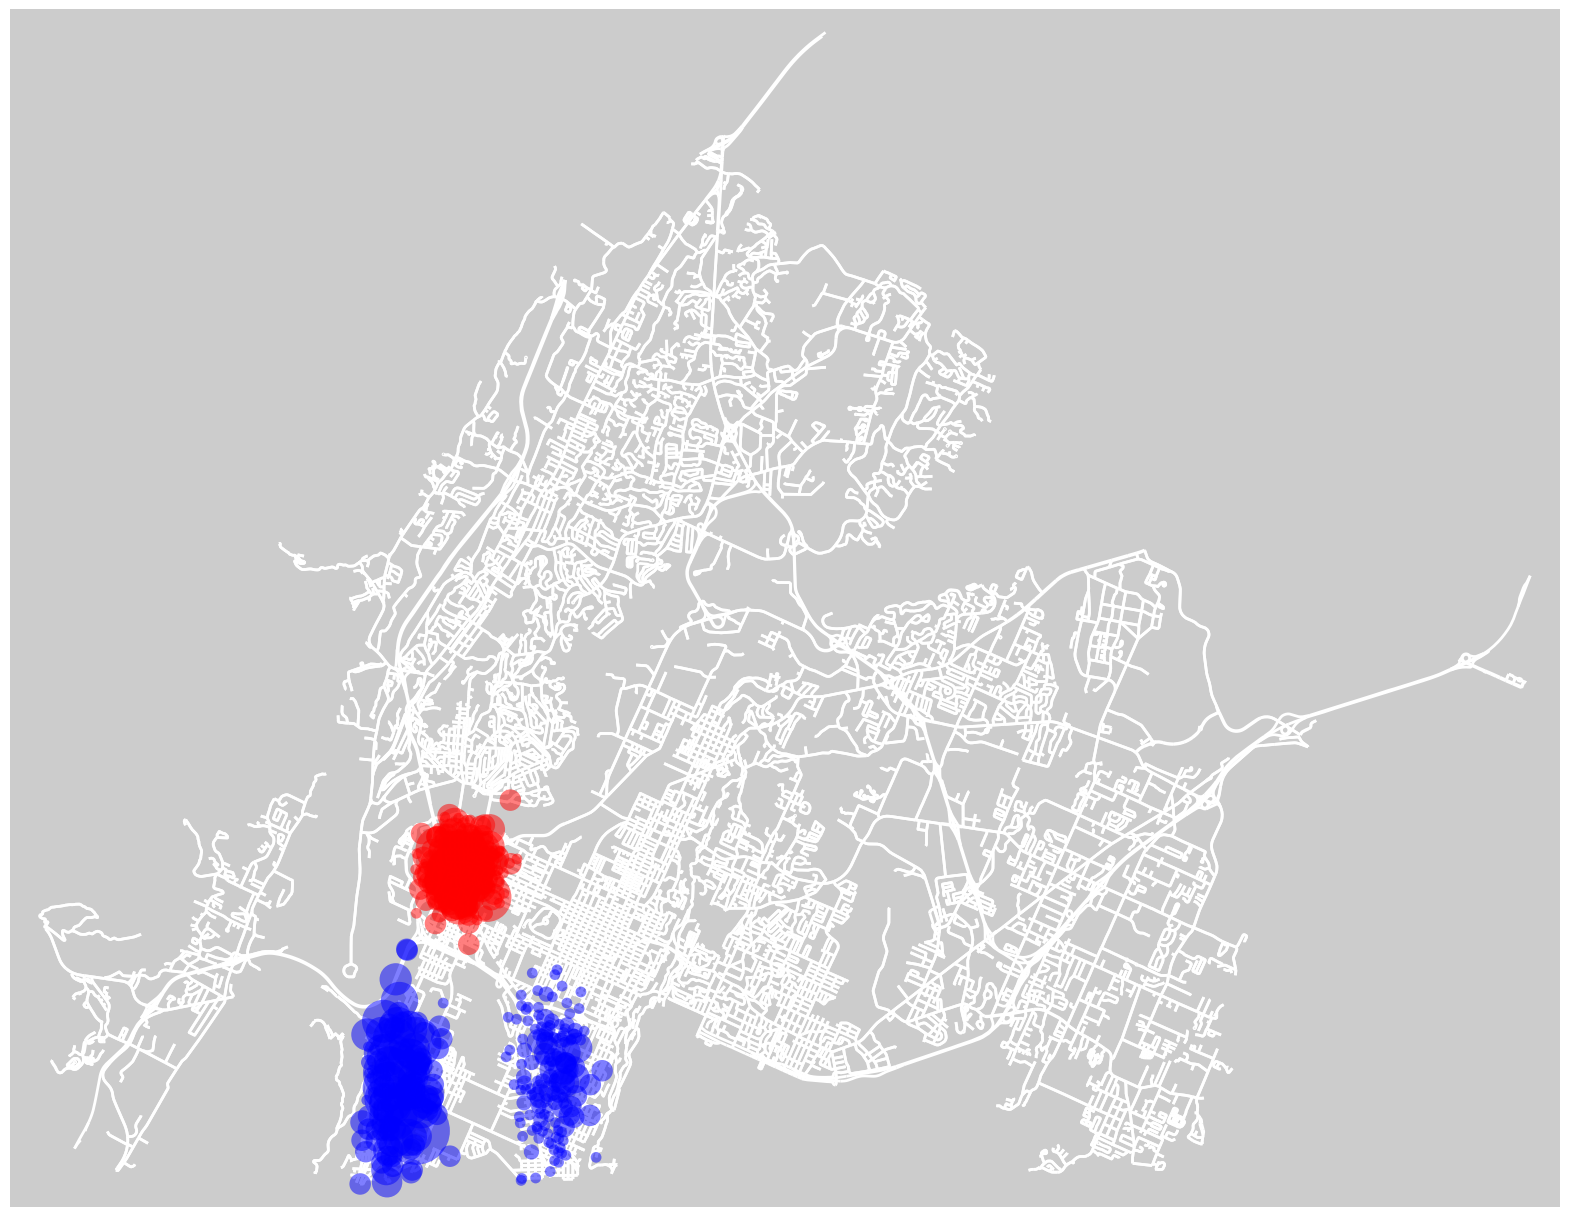

In [17]:
plotODs(GRAPHS,SIZES,NODES,scale=1.)

# SETUP NODES DATAFRAME (takes 10 min...)

In [13]:
from multimodal_functions import * 
NDF = []
# ndfs_to_rerun = ['gtfs','transit','delivery1','delivery2','source','target'];
ndfs_to_rerun = ['delivery1','delivery2','source','target'];
NDF = SETUP_NODESDF_CHATTANOOGA(GRAPHS,NODES,NDF=NDF,ndfs_to_rerun=ndfs_to_rerun)
#BUS_STOP_NODES = INITIALIZING_BUSSTOPCONVERSION_CHATTANOOGA(GRAPHS);
BUS_STOP_NODES = {};

time to create nodes...:  0.0009629726409912109
starting delivery1 sources...
0
starting delivery2 sources...
0
starting source nodes...
0
200
400
600
800
1000
starting target nodes...
0
200
400
600
800
1000
time to create nodes...:  262.18441820144653


In [2]:
print(NDF['drive'])

NameError: name 'NDF' is not defined

# WORLD

In [9]:
%load_ext autoreload
%autoreload 2

from multimodal_functions import * 

graph = GRAPHS['drive']
nodes = list(graph.nodes())

factors = ['time','money','conven','switches'];
people_tags = list(PRE)
num_people = len(people_tags);
num_people = len(LOCS['orig']);          # 
modes = ['drive','ondemand','walk','transit','gtfs'];
graphs = ['drive','ondemand','walk','transit','gtfs'];
    
params = {}
params['modes'] = modes; params['graphs'] = graphs; params['nodes'] = nodes;
params['people_tags'] = people_tags; params['factors'] = factors;

WORLD = generateWorld(GRAPHS,params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
trip = list(WORLD['walk']['trips'])[0]
print(trip)
print(WORLD['walk']['trips'][trip]['costs']['time']);#.keys())
# print(WORLD['drive']['edge_costs'][(442982401, 442982396, 0)])
# print(WORLD['drive']['edge_masses'][(442982401, 442982396, 0)])
# print(WORLD['drive']['current_edge_masses'][(442982401, 442982396, 0)])

(202596779.0, 6853979104.0)
[104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418, 104.78747203579418]


## DELIVERY 

In [10]:
%load_ext autoreload
%autoreload 2

from multimodal_functions import * 

params = {}
params['direct_locs'] = LOCS['delivery1']; params['shuttle_locs'] = LOCS['delivery2'];
params['NODES'] = NODES;
# params['BUS_STOP_NODES'] = BUS_STOP_NODES;

DELIVERY = generateDeliveries(GRAPHS,NDF,params);   
DELIVERY2 = DELIVERY['shuttle']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
updateNodesDF(NDF);

In [93]:
print(DELIVERY['direct'])

{'delivery1_0': {'active_trips': [], 'active_trip_history': [[], [], [(202643883.0, 7618250431.0), (202643883.0, 7618250431.0), (202574589.0, 1845517702.0), (1025136839.0, 202633685.0), (1025136839.0, 202633685.0), (202636884.0, 202692612.0), (202636884.0, 202692612.0), (202603917.0, 202735923.0)], [], [], [], [], [], [], [], [], []], 'loc': array([-85.30526716,  35.04608948]), 'current_path': [202633685, 202633693, 202633696, 202638669, 202641423, 202596708, 202596716, 202641753, 202597502, 202640338, 202644801, 202648876, 202651210, 202749900, 450289085, 5951158526, 11097239235, 202574056, 202563255, 10681502806, 202735043, 202613445, 202613449, 202598539, 202648916, 202648920, 202648952, 202751796, 202745638, 202629802, 202636643, 202639186, 202739369, 1025136839.0, 1025136839.0, 1025136839.0, 202636872, 202636873, 202636875, 202643883.0, 202643883.0, 202643883.0, 202636875, 202636877, 202636884.0, 202636884.0, 202636884.0, 202636877, 202636875, 202636873, 202636872, 1025136839, 102

#### PEOPLE, DELIVERY - INITIALIZATION (takes 20 MIN...(40 people/min))

In [12]:
%load_ext autoreload
%autoreload 2

from multimodal_functions import * 

modes = ['drive','transit','ondemand','walk','gtfs']
params = {}
params['modes'] = modes; params['graphs'] = graphs;
params['nodes'] = nodes; params['factors'] = factors; params['mass_scale'] = 4./3600.
asdf = generatePopulation(GRAPHS,DELIVERY,WORLD,NDF,VEHS,LOCS,PRE,params,verbose = False);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GENERATING POPULATION OF 615 ...
person0
time to add 10 people:  2.6226043701171875e-05
nan found...after conversion... 7143261828.0
nan found...after conversion... 202636728.0
nan found...after conversion... 9896007584.0
nan found...after conversion... 9311247872.0
nan found...after conversion... 7099094597.0
person10
time to add 10 people:  16.656044960021973
nan found...after conversion... 3536712123.0
nan found...after conversion... 3931185492.0
nan found...after conversion... 7100482618.0
nan found...after conversion... 9896013828.0
nan found...after conversion... 1796588181.0
person20
time to add 10 people:  17.704973220825195
nan found...after conversion... 7619438630.0
nan found...after conversion... 7143261829.0
nan found...after conversion... 926017743.0
nan found...after conversion... 7148070474.0
nan found...after conversion... 7084939210.0
person30
time to add 10 people:  17.47383570671

In [91]:
# print(PEOPLE['person0'].keys())
# print(list(PEOPLE['person0']['trips']))
trip = list(PEOPLE['person0']['trips'])[3]
print(PEOPLE['person0']['trips'][trip]['structure'][0])
print(PEOPLE['person0']['trips'][trip]['structure'][1])
print(PEOPLE['person0']['trips'][trip]['structure'][2])



{'mode': 'ondemand', 'start_nodes': [202636472.0], 'end_nodes': [1432383382.0], 'path': [], 'delivery': None, 'opt_start': 202636472.0, 'opt_end': 1432383382.0}
{'mode': 'gtfs', 'start_nodes': ['1129'], 'end_nodes': ['2078'], 'path': [], 'opt_start': '1129', 'opt_end': '2078'}
{'mode': 'walk', 'start_nodes': [202596779.0], 'end_nodes': [6853979104.0], 'path': [], 'opt_start': 202596779.0, 'opt_end': 6853979104.0}


In [13]:
PEOPLE = asdf;

In [14]:
updateNodesDF(NDF);

In [15]:
#PRE['person0']
print(num_people)

615


# ----------------- PRELOADED DATA START ---------------------------
# ----------------- PRELOADED DATA START ---------------------------


# LOAD DATA (default: False)

In [56]:
reload_data = True;
#filename = 'data/data1176.obj'
# filename = 'data/data1073.obj'
# filename = 'data/data353.obj'
# filename = 'data/data103.obj'
# filename = 'data/small_data287.obj'
# filename = 'data/small_data228_select.obj'
# filename = 'data/small_data233_select.obj'
filename = 'runs/small_data306_select.obj'

# import pandas as pd

# df = pd.read_pickle("file.pkl")

if reload_data:
    #feed = pt.get_representative_feed('carta_gtfs.zip') #loading gtfs from chattanooga
    feed = gtfs.Feed('carta_gtfs.zip', time_windows=[0, 6, 10, 12, 16, 19, 24])
    file = open(filename, 'rb')
    DATA = pickle.load(file)
    DATA = pd.read_pickle(filename)
    file.close()
    
reread_data = True;
if reread_data:
    asdf = DATA['PEOPLE']
    WORLD = DATA['WORLD']
    DELIVERY = DATA['DELIVERY']
    NDF = DATA['NDF']
    #GRAPHS = DATA['GRAPHS']
    PRE = DATA['PRE'];
    BUS_STOP_NODES = DATA['BUS_STOP_NODES']
    NODES = DATA['NODES']
    LOCS = DATA['LOCS']    
    SIZES = DATA['SIZES']
GRAPHS['gtfs'] = feed;

# for i,tag in enumerate(PEOPLE):
#     # PEOPLE[tag]['mass_total'] = PEOPLE[tag]['mass']
#     # PEOPLE[tag]['mass'] = 4*PEOPLE[tag]['mass_total']/(3600);
#     print(PEOPLE[tag]['mass'])

### ... ASSIGN PEOPLE (default: False)

In [57]:
assign_people = True;
if assign_people: 
    PEOPLE = asdf;

# LOAD GTFS (default: True)

In [58]:
import pickle
import os.path

reload_gtfs = True;
filename = 'data/gtfs/gtfs_trips.obj'
if reload_gtfs:
    file = open(filename, 'rb')
    data = pickle.load(file)
    file.close()

    REACHED_NODES = data['REACHED_NODES']
    PREV_NODES = data['PREV_NODES']
    PREV_TRIPS = data['PREV_TRIPS']



### ... ASSIGN GTFS (default: True)

In [59]:
assign_gtfs = False;
WORLD['gtfs']['precompute'] = {};
WORLD['gtfs']['precompute']['reached'] = REACHED_NODES;
WORLD['gtfs']['precompute']['prev_nodes'] = PREV_NODES;
WORLD['gtfs']['precompute']['prev_trips'] = PREV_TRIPS;


In [60]:
print(WORLD.keys())

dict_keys(['main', 'drive', 'ondemand', 'walk', 'transit', 'gtfs'])


# SAVE DATA (default: False)

In [22]:
# #### DON"T CHANGE 
rewrite_data = True; 
num_people = len(list(PEOPLE))
filename = 'data/small_data'+str(num_people)+'_select.obj'
# filename = 'current.obj'
# if os.path.isfile(filename):
#     filename
# import pickle
# import os.path
# filename = 'gtfs_trips.obj'
# if os.path.isfile(filename):

if rewrite_data:
    fileObj = open(filename, 'wb')
    GRAPHSnoGTFS = {}
    for j,mode in enumerate(GRAPHS):
        if not(mode == 'gtfs'):
            GRAPHSnoGTFS[mode] = GRAPHS[mode]
            
    DATA = {
            'PEOPLE':PEOPLE,
            'WORLD':WORLD,
            'DELIVERY':DELIVERY,
            'NDF':NDF,
            'NODES':NODES,
            'LOCS':LOCS,
            'PRE':PRE,        
            'BUS_STOP_NODES':BUS_STOP_NODES,
            # 'GRAPHS':GRAPHSnoGTFS,
            'SIZES':SIZES
           }
#             'GRAPHS':GRAPHS}
    pickle.dump(DATA,fileObj)
    fileObj.close()


# -------------- MAIN SIMULATION ------------------
# -------------- MAIN SIMULATION ------------------

In [54]:
add_base_edge_masses(GRAPHS,WORLD,WORLD0);

In [96]:
%load_ext autoreload
%autoreload 2

from multimodal_functions import * 

WORLD['main'] = {}
WORLD['main']['iter'] = 0.;
WORLD['main']['alpha'] = 1./(WORLD['main']['iter']+1.);

nk = 2; 
for k in range(nk):
    start_time = time.time();
    print('------------------ITERATION',int(WORLD['main']['iter']),'-----------')
    # alpha =1/(k+10.);

    world_of_gtfs(WORLD,PEOPLE,GRAPHS,NDF,verbose=True);    
    world_of_drive(WORLD,PEOPLE,GRAPHS,verbose=True); #graph,costs,sources, targets):    
    world_of_ondemand(WORLD,PEOPLE,DELIVERY,GRAPHS,verbose=True,show_delivs='all');
    world_of_walk(WORLD,PEOPLE,GRAPHS,verbose=True); #graph,costs,sources, targets):    
    #world_of_transit_graph(WORLD,PEOPLE,GRAPHS,verbose=True);
    

    print('updating individual choices...')
    update_choices(PEOPLE, DELIVERY, NDF, GRAPHS,WORLD,takeall=False);
    end_time = time.time()
    
    print('iteration time: ',end_time-start_time)
    WORLD['main']['iter'] = WORLD['main']['iter'] + 1.;
    WORLD['main']['alpha'] = 1./(WORLD['main']['iter']+1.);


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
------------------ITERATION 0 -----------
starting gtfs computations...
...with  272  active trips...
REMOVING MASS FROM GTFS TRIPS...
starting driving computations...


KeyError: (202545732, 202743773, 0)

# ---------- GRAPHING --------------

In [97]:
%load_ext autoreload
%autoreload 2
from multimodal_functions import *

import warnings
warnings.filterwarnings('ignore')

fileName = 'current.pdf'

shows = {'drive': False,
         'walk':False,
         'transit':False,
         'ondemand': False,
         'direct':False,
         'shuttle':False,
         'ondemand_indiv':False,
         'lines':True,
         'gtfs':False,
         'source':False,
         'target':False,
         'legend':True,
         'base':True}
maxwids = {'drive': 10.,'walk':6,'transit':10,'lines':4,'gtfs':10,'ondemand':2,'direct':1,
            'ondemand_indiv':10,'base':4.}

colors = {'shuttle':[1,0.5,0.5]}

# mxpop1 = 1.
mxpops = {'drive': 1.,'walk':1,'transit':1,'lines':1,'gtfs':1,'ondemand':1}

params = generate_graph_presets(fileName,shows,WORLD,maxwids,mxpops,other_edges = True)
params['SIZES'] = SIZES;
params['colors']['shuttle'] = [0.,0.,1.]
params['set_alphas'] = {'direct':0.6,'shuttle':0.6}
params['set_wids'] = {'direct':4,'shuttle':4}
                         
start_time = time.time()
cmap = plt.get_cmap('autumn')
plot_multimode(GRAPHS,NODES,DELIVERY,WORLD,params);


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyError: ('211', '212', 0)

# TEST SECTION

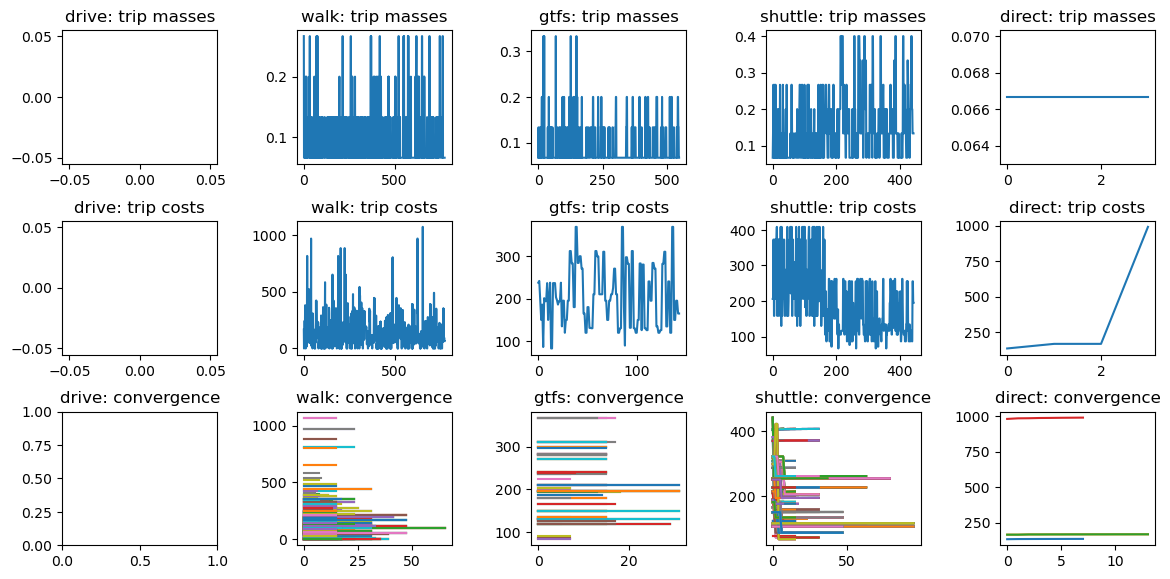

In [37]:
show_edges = False;
show_trips = True;

edgeMasses = {};
edgeCosts = {};
tripCosts = {};
tripMasses = {};
modes = ['drive','gtfs','walk','ondemand']

if show_edges:
    fig1,axs = plt.subplots(3,4,figsize=(12,6));
    fig1.tight_layout(pad=2.0)
    typtoshow = 'current_edge_masses'
    rowind = 0; 
    for m,mode in enumerate(modes):
        edgeMasses[mode] = [];
        for e,edge in enumerate(WORLD[mode][typtoshow]):
            edgeMasses[mode].append(WORLD[mode][typtoshow][edge])
        axs[rowind][m].set_title(mode+': '+typtoshow[8:]);
        axs[rowind][m].plot(edgeMasses[mode])
    
    typtoshow = 'current_edge_costs'
    rowind = 1; rowind2 = 2;
    for m,mode in enumerate(modes):
        edgeCosts[mode] = [];
        for e,edge in enumerate(WORLD[mode][typtoshow]):
            costs = WORLD[mode]['edge_costs'][edge]
            edgeCosts[mode].append(WORLD[mode][typtoshow][edge])
            if np.abs(costs[0]-costs[-1]) > 0.01:
                axs[rowind2][m].plot(costs)
    
        axs[rowind][m].set_title(mode+': '+typtoshow[8:]);
        axs[rowind][m].plot(edgeCosts[mode])


########################################################################################
########################################################################################
print('')
print('')
print('')

toshows = ['drive','walk','gtfs','shuttle','direct']
rowinds = [0,1,2];
if show_trips:
    fig2,axs = plt.subplots(3,len(toshows),figsize=(12,6));
    fig2.tight_layout(pad=2.0)
    
    typtoshow = 'trips'
    # rowind = 0;
    # for m,mode in enumerate(modes):
        
    #     for tt,trip in enumerate(WORLD[mode]['active_trips']):
    #         cost = WORLD[mode]['trips'][trip]['mass']
    #         tripMasses[mode].append(cost)
    
    
    typtoshow = 'trips'
    rowind = 1; rowind2 = 2;
    for m,toshow in enumerate(toshows):
        tripMasses[toshow] = [];
        tripCosts[toshow] = [];
        if toshow == 'shuttle':
            mode = 'ondemand';
            active_trips = WORLD[mode]['active_trips_shuttle'];
        elif toshow == 'direct':
            mode = 'ondemand';
            active_trips = WORLD[mode]['active_trips_direct'];
        else:
            mode = toshow;
            active_trips = WORLD[mode]['active_trips'];

        for tt,trip in enumerate(active_trips):

            tripMasses[toshow].append(WORLD[mode]['trips'][trip]['mass'])
            
            costs = WORLD[mode]['trips'][trip]['costs']['time']
            # if True: #len(costs)<nk:
            # print(costs[-1])
            if len(costs)>0:
                if costs[-1]<1000000000:
                    tripCosts[toshow].append(costs[-1])
                    if True: #np.abs(costs[0]-costs[-1]) > 0.01:
                        axs[rowinds[2]][m].plot(costs)

        axs[rowinds[0]][m].set_title(toshow+': '+'trip masses');
        axs[rowinds[0]][m].plot(tripMasses[toshow])
        
        axs[rowinds[1]][m].set_title(toshow+': '+'trip costs');
        axs[rowinds[1]][m].plot(tripCosts[toshow])

        axs[rowinds[2]][m].set_title(toshow+': '+'convergence');


    
        


#  END OF WORKING #  END OF WORKING #  END OF WORKING # 
#  END OF WORKING #  END OF WORKING #  END OF WORKING # 
#  END OF WORKING #  END OF WORKING #  END OF WORKING # 

# METRICS AND PLOTS

In [4]:
# Format of dataframe1(Population info):

# Index: segment (start_node,end_node) 
# Columns: 
# people:  ex. [‘person0,person1,person2,...] list of tags for agents using trip segment
# mode:  mode for trip segment
# distance: 
# time:
# money:
# uncongested_distance:  travel distance with no congestion
# uncongested_time:   travel time with no congestion
# pickup_time: time of pickup (relative to start of pickup time window) - for ondemand trips
# dropoff_time: time of dropoff (relative to end of dropoff time window) - for ondemand trips

# Format of dataframe2 (ondeamnd info):

# Index: driver_run_id
# Columns: 
# group: ondemand delivery group
# distance: distance of driver run
# time: travel time of driver run
# total_passengers: 
# time_wpassengers:  list of time spent with each number of passengers
# ex. [time with 0 passengers, time with 1 passenger, time with 2 passengers, …]
# distance_wpassengers: list of distance traveled with each number of passengers..
# ex. [distance with 0 passengers, distance with 1 passenger, distance with 2 passengers,…]

## Travel time and travel distance for each person

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



# Preprocess Dataframe1 to extract individual people
def extract_people(row):
    return [(person, row['distance'], row['time']) for person in row['people'].split(',')]

# Apply the function and create a new DataFrame
people_data = dataframe1.apply(extract_people, axis=1).explode()
people_df = pd.DataFrame(people_data.tolist(), columns=['person', 'distance', 'time'])

# Group by person and sum distance and time
grouped_people = people_df.groupby('person').sum().reset_index()


# Plotting total distance traveled by each person
plt.figure(figsize=(10, 6))
plt.bar(grouped_people['person'], grouped_people['distance'])
plt.xlabel('Person')
plt.ylabel('Total Distance Traveled')
plt.title('Total Distance Traveled by Each Person')
plt.xticks(rotation=45)
plt.show()

# Plotting total time traveled by each person
plt.figure(figsize=(10, 6))
plt.bar(grouped_people['person'], grouped_people['time'])
plt.xlabel('Person')
plt.ylabel('Total Time Traveled')
plt.title('Total Time Traveled by Each Person')
plt.xticks(rotation=45)
plt.show()

## Travel time/ Uncongested Travel Time and Travel distance/ Uncongested Travel Distance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to extract people and their travel metrics
def extract_people_metrics(row):
    return [(person, row['time'], row['uncongested_time'], row['distance'], row['uncongested_distance']) 
            for person in row['people'].split(',')]

# Apply the function and create a new DataFrame
people_metrics = dataframe1.apply(extract_people_metrics, axis=1).explode()
people_df = pd.DataFrame(people_metrics.tolist(), 
                         columns=['person', 'time', 'uncongested_time', 'distance', 'uncongested_distance'])

# Group by person and sum the metrics
grouped_people = people_df.groupby('person').sum().reset_index()

# Compute the ratios
grouped_people['time_ratio'] = grouped_people['time'] / grouped_people['uncongested_time']
grouped_people['distance_ratio'] = grouped_people['distance'] / grouped_people['uncongested_distance']

# Box Plot for Total Time Ratio
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_people['time_ratio'], vert=False)
plt.xlabel('Total Time Ratio (Time / Uncongested Time)')
plt.title('Box Plot of Total Time Ratio for Each Person')
plt.show()

# Box Plot for Total Distance Ratio
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_people['distance_ratio'], vert=False)
plt.xlabel('Total Distance Ratio (Distance / Uncongested Distance)')
plt.title('Box Plot of Total Distance Ratio for Each Person')
plt.show()

## Monetary cost by person


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to extract people and their monetary costs
def extract_people_costs(row):
    return [(person, row['money']) for person in row['people'].split(',')]

# Apply the function and create a new DataFrame for people and their costs
people_costs = dataframe1.apply(extract_people_costs, axis=1).explode()
people_costs_df = pd.DataFrame(people_costs.tolist(), columns=['person', 'money'])

# Group by person and sum the monetary costs
grouped_costs = people_costs_df.groupby('person').sum().reset_index()

# Plotting a histogram of the total monetary costs
plt.figure(figsize=(10, 6))
plt.hist(grouped_costs['money'], bins=30, edgecolor='black')
plt.xlabel('Total Monetary Cost')
plt.ylabel('Number of People')
plt.title('Distribution of Total Monetary Costs Across People')
plt.show()


## Travel time/ Uncongested travel time by different modes 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


dataframe1['time_ratio'] = dataframe1['time'] / dataframe1['uncongested_time']
dataframe1['distance_ratio'] = dataframe1['distance'] / dataframe1['uncongested_distance']

# Replace infinite values and NaNs (if uncongested time or distance is zero)
dataframe1.replace([float('inf'), -float('inf'), np.nan], 0, inplace=True)

# Group by Mode
grouped_by_mode = dataframe1.groupby('mode')


# Plotting Time Ratios
plt.figure(figsize=(10, 6))
sns.boxplot(x='mode', y='time_ratio', data=dataframe1)
plt.xlabel('Mode of Transportation')
plt.ylabel('Travel Time / Uncongested Travel Time Ratio')
plt.title('Time Ratio by Mode of Transportation')
plt.show()

# Plotting Distance Ratios
plt.figure(figsize=(10, 6))
sns.boxplot(x='mode', y='distance_ratio', data=dataframe1)
plt.xlabel('Mode of Transportation')
plt.ylabel('Travel Distance / Uncongested Travel Distance Ratio')
plt.title('Distance Ratio by Mode of Transportation')
plt.show()

## Number of Bus Transfers

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extracting people and filtering for transit mode
dataframe1['people_list'] = dataframe1['people'].str.split(',')
transit_trips = dataframe1[dataframe1['mode'] == 'transit'].explode('people_list')

# Counting transit trip segments
segment_count_per_person = transit_trips.groupby('people_list').size().reset_index(name='segment_count')

# Calculating transfers (transfers = segments - 1)
segment_count_per_person['transfers'] = segment_count_per_person['segment_count'] - 1

# Replace negative transfers with 0 (for those with only one segment)
segment_count_per_person['transfers'] = segment_count_per_person['transfers'].clip(lower=0)

plt.figure(figsize=(10, 6))
plt.boxplot(segment_count_per_person['transfers'], vert=False)
plt.xlabel('Number of Transfers')
plt.title('Number of Bus Transfers per Person')
plt.show()

## Miles travelled by each vehicle and percentage of time spent with N number of passengers

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting Miles Traveled for Each Ondemand Vehicle
plt.figure(figsize=(10, 6))
plt.bar(dataframe2.index, dataframe2['distance'])
plt.xlabel('Ondemand Vehicle ID')
plt.ylabel('Miles Traveled')
plt.title('Miles Traveled by Each Ondemand Vehicle')
plt.xticks(rotation=45)
plt.show()

# Calculating and Plotting Percentages of Time & Distance with Different Passenger Counts
# Assuming time_wpassengers and distance_wpassengers are lists within the DataFrame

# Convert string representations of lists to actual lists (if necessary)
# import ast
# dataframe2['time_wpassengers'] = dataframe2['time_wpassengers'].apply(ast.literal_eval)
# dataframe2['distance_wpassengers'] = dataframe2['distance_wpassengers'].apply(ast.literal_eval)

total_time = dataframe2['time_wpassengers'].apply(sum)
total_distance = dataframe2['distance_wpassengers'].apply(sum)

# Calculate percentages
time_percentages = dataframe2['time_wpassengers'].apply(lambda x: [i/sum(x)*100 for i in x])
distance_percentages = dataframe2['distance_wpassengers'].apply(lambda x: [i/sum(x)*100 for i in x])

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Time percentages
axes[0].stackplot(dataframe2.index, time_percentages.T)
axes[0].set_title('Percentage of Time with N Passengers')
axes[0].set_xlabel('Ondemand Vehicle ID')
axes[0].set_ylabel('Percentage')
axes[0].legend([f'{i} Passengers' for i in range(len(time_percentages.iloc[0]))], loc='upper left')

# Distance percentages
axes[1].stackplot(dataframe2.index, distance_percentages.T)
axes[1].set_title('Percentage of Distance with N Passengers')
axes[1].set_xlabel('Ondemand Vehicle ID')
axes[1].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

## Early Arrival Margin

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Filter for ondemand trips
ondemand_trips = dataframe1[dataframe1['mode'] == 'ondemand']
ondemand_trips['people_list'] = ondemand_trips['people'].str.split(',')

# Explode the DataFrame to have a row for each person in each trip
individual_trips = ondemand_trips.explode('people_list')

# Compute the early dropoff times
individual_trips['early_dropoff'] = individual_trips.apply(
    lambda x: PRE[x['people_list']]['arrival_time_end'] - x['dropoff_time'] if x['people_list'] in PRE and 'arrival_time_end' in PRE[x['people_list']] else None,
    axis=1
)

# Filter out rows where early dropoff time couldn't be calculated
individual_trips = individual_trips.dropna(subset=['early_dropoff'])

# Plotting the early dropoff times
plt.figure(figsize=(10, 6))
plt.boxplot(individual_trips['early_dropoff'], vert=False)
plt.xlabel('Early Dropoff Time')
plt.title('Box Plot of Early Dropoff Times for Ondemand Trips')
plt.show()

## PMT/VMT 

# SAVE POPULATION DATA?

In [ ]:

save_pop_data = False;
home_locs = NODES['orig'];
work_locs = NODES['dest'];
if save_pop_data:
    ASDF = {}
    ASDF['home_locs'] = home_locs;
    ASDF['work_locs'] = work_locs;
    ASDF['home_sizes'] = home_sizes;
    ASDF['work_sizes'] = work_sizes;
    ASDF['home_nodes'] = home_nodes;
    ASDF['work_nodes'] = work_nodes;

    fileObj = open('ods10k.obj', 'wb')
    pickle.dump(ASDF,fileObj)
    fileObj.close()

# RECOMPUTE GTFS FEED (takes 2 hrs...)

In [ ]:
recompute = False;
if recompute: 
    asdf = calculateGTFStrips(feed); # SOLVED = 
    fileObj = open('gtfs_trips2.obj', 'wb')
    pickle.dump(SOLVED,fileObj)
    fileObj.close()

# START NEW ---------- 
# TYPE CODE - GRAPH PLOTS

## ----------------- END SANDBOX --------------------END SANDBOX --------------------